# Siamese neural networks, *one-shot learning* on Omniglot dataset

This notebook presents the paper ["Siamese Neural Networks for One-shot Image Recognition"](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) coded with PyTorch framework. 

- Siamese neural networks -> image similarity task
- *one-shot learning* = predict the class of a test image comparing it with a set of single examples of each possible class

```

test image ------[CNN]---- features ----\
                                         \
train image 1 ---[CNN]---- features ---[is same?] ---- Proba class 1
train image 2 ---[CNN]---- features ---[is same?] ---- Proba class 2  
    ...                                  
train image N ---[CNN]---- features ---[is same?] ---- Proba class N

```

References:
- [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
- [omniglot](https://github.com/brendenlake/omniglot)
- [keras-oneshot](https://github.com/sorenbouma/keras-oneshot)


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import cv2

In [3]:
sys.path.append(".")

## Model

- 2 convolutional neural networks with shared weights
- standard verification task : discriminate between the class-identity of image pairs
    - `{ball, dog} ---[Siamese network] --- false`
    - `{ball1, ball2} ---[Siamese network] --- true`
    
### CNN

#### Architecture 

Single image encoding CNN is defined as 
```
---[C|R]---[P] ->-[C|R]---[P]->-[C|R]---[P]->-[C|R]---[Flatten]---[FC|Sigmoid]---
   64      2x2     128    2x2    128    2x2    256
   10x10           7x7           4x4           4x4
```
where `C` is 2D convolution, `R` - ReLU activation, `P` - max-pooling, `FC` - fully-connected layer

Complete network is defined as
```
input1 --- [CNN]---\
                 [merge]---[Dense]---output
input2 --- [CNN]---/
```
where `merge` is L1 component-wise distance between vectors


#### Weight initialization

- Convolution layers: 
    - Kernel : normal distribution with $\mu=0$ and $\sigma=10^{-2}$
    - Bias : normal distribution with $\mu=0.5$ and $\sigma=10^{-2}$
- Fully-connected layers: 
    - Kernel : normal distribution with $\mu=0$ and $\sigma=2 \cdot 10^{-1}$
    - Bias : normal distribution with $\mu=0.5$ and $\sigma=10^{-2}$


In [4]:
import torch
from torch.nn import Module, Sequential
from torch.nn import Linear, Conv2d, MaxPool2d, Sigmoid, ReLU, PairwiseDistance
from torch.autograd import Variable
torch.__version__

'0.2.0_3'

In [5]:
from common.nn_utils import print_trainable_parameters

In [6]:
class Flatten(Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [7]:
class Net(Module):
    
    def __init__(self, input_shape):
        """
        :param input_shape: input image shape, (h, w, c)
        """
        super(Net, self).__init__()
        
        self.features = Sequential(            
            Conv2d(input_shape[-1], 64, kernel_size=10),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=2),
            
            Conv2d(64, 128, kernel_size=7),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=2),

            Conv2d(128, 128, kernel_size=4),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=2),            
            
            Conv2d(128, 256, kernel_size=4),
            ReLU()        
        )
        
        # Compute number of input features for the last fully-connected layer
        input_shape = (1, ) + input_shape[::-1]
        x = Variable(torch.rand(input_shape), requires_grad=False)
        x = self.features(x)
        x = Flatten()(x)
        n = x.size()[1]
        
        self.classifier = Sequential(
            Flatten(),
            Linear(n, 4096),
            Sigmoid()
        )     
        
    def forward(self, x):        
        x = self.features(x)
        x = self.classifier(x)
        return x

In [8]:
class SiameseNetworks(Module):
    
    def __init__(self, input_shape):
        """
        :param input_shape: input image shape, (h, w, c)
        """
        super(SiameseNetworks, self).__init__()
        self.net = Net(input_shape)
                
        self.classifier = Sequential(
            Linear(4096, 1, bias=False),
            Sigmoid()
        )        
        self._weight_init()  
        
    def _weight_init(self):
        for m in self.modules():
            if isinstance(m, Conv2d):
                m.weight.data.normal_(0, 1e-2)
                m.bias.data.normal_(0.5, 1e-2)
            elif isinstance(m, Linear):
                m.weight.data.normal_(0, 2.0*1e-1)
                if m.bias is not None:
                    m.bias.data.normal_(0.5, 1e-2) 
    
    def forward(self, x1, x2):        
        x1 = self.net(x1)
        x2 = self.net(x2)        
        # L1 component-wise distance between vectors:
        x = torch.pow(torch.abs(x1 - x2), 2.0)      
        return self.classifier(x)

In [9]:
siamese_net = SiameseNetworks(input_shape=(105, 105, 1))
siamese_net = siamese_net.cuda()

In [10]:
print_trainable_parameters(siamese_net)

net.features.0.weight torch.Size([64, 1, 10, 10])
net.features.0.bias torch.Size([64])
net.features.3.weight torch.Size([128, 64, 7, 7])
net.features.3.bias torch.Size([128])
net.features.6.weight torch.Size([128, 128, 4, 4])
net.features.6.bias torch.Size([128])
net.features.9.weight torch.Size([256, 128, 4, 4])
net.features.9.bias torch.Size([256])
net.classifier.1.weight torch.Size([4096, 9216])
net.classifier.1.bias torch.Size([4096])
classifier.0.weight torch.Size([1, 4096])

Total number of trainable parameters:  38951744


In [11]:
input_shape = (2, 1, 105, 105)
x = Variable(torch.rand(input_shape), requires_grad=False).cuda()
y = siamese_net(x, x)
y.size()

torch.Size([2, 1])

### One-shot learning

> *Classification under the restriction that we may only observe a single example of each possible class before making a prediction about a test instance*

Once trained siamese network can be used to classify previously unseen data and classes (being not too far from training data). Previously unseen means, for example, Siamese network is trained on latin and greek alphabets and one-shot learning evaluation is performed on the cyrillic alphabet.

~~Let's previously unseen data is composed of $C$ classes.~~


## Omniglot dataset

This dataset contains 1623 different handwritten characters from 50 different alphabets.
Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.

In [12]:
# !unzip --help 

if not os.path.exists("omniglot"):
    !git clone https://github.com/brendenlake/omniglot
    !cd omniglot/python/ && unzip images_background.zip        
    !cd omniglot/python/ && unzip images_background_small1.zip
    !cd omniglot/python/ && unzip images_background_small2.zip    
    !cd omniglot/python/ && unzip images_evaluation.zip

In [13]:
import matplotlib.pylab as plt
%matplotlib inline

In [14]:
TRAIN_DATA_PATH = "omniglot/python/images_background/"
train_alphabets = !ls {TRAIN_DATA_PATH}
train_alphabets = list(train_alphabets)
print("\nTrain alphabets: \n", train_alphabets, len(train_alphabets))

TEST_DATA_PATH = "omniglot/python/images_evaluation/"
test_alphabets = !ls {TEST_DATA_PATH}
test_alphabets = list(test_alphabets)
print("\nEvaluation alphabets: \n", test_alphabets, len(test_alphabets))


Train alphabets: 
 ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'] 30

Evaluation alphabets: 
 ['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG'] 20


In [15]:
train_alphabet_char_id_drawer_ids = {}
for a in train_alphabets:
    res = !ls "{TRAIN_DATA_PATH}/{a}"
    char_ids = list(res)
    train_alphabet_char_id_drawer_ids[a] = {}
    for char_id in char_ids:
        res = !ls "{TRAIN_DATA_PATH}/{a}/{char_id}"
        train_alphabet_char_id_drawer_ids[a][char_id] = [_id[:-4] for _id in list(res)]

In [16]:
test_alphabet_char_id_drawer_ids = {}
for a in test_alphabets:
    res = !ls "{TEST_DATA_PATH}/{a}"
    char_ids = list(res)
    test_alphabet_char_id_drawer_ids[a] = {}
    for char_id in char_ids:
        res = !ls "{TEST_DATA_PATH}/{a}/{char_id}"
        test_alphabet_char_id_drawer_ids[a][char_id] = [_id[:-4] for _id in list(res)]

In [17]:
print("Characters of 'Alphabet_of_the_Magi': \n", train_alphabet_char_id_drawer_ids['Alphabet_of_the_Magi'].keys())

Characters of 'Alphabet_of_the_Magi': 
 dict_keys(['character01', 'character10', 'character09', 'character08', 'character05', 'character02', 'character20', 'character14', 'character16', 'character06', 'character04', 'character18', 'character13', 'character17', 'character11', 'character07', 'character19', 'character03', 'character12', 'character15'])


In [18]:
print("Images of a single character of 'Alphabet_of_the_Magi': \n", 
      train_alphabet_char_id_drawer_ids['Alphabet_of_the_Magi']['character01'])

Images of a single character of 'Alphabet_of_the_Magi': 
 ['0709_01', '0709_02', '0709_03', '0709_04', '0709_05', '0709_06', '0709_07', '0709_08', '0709_09', '0709_10', '0709_11', '0709_12', '0709_13', '0709_14', '0709_15', '0709_16', '0709_17', '0709_18', '0709_19', '0709_20']


In [19]:
def get_image(group, char_id, _id, _type="Train"):    
    assert _type in ["Train", "Test"]
    path = TRAIN_DATA_PATH if _type == "Train" else TEST_DATA_PATH
    path = os.path.join(path, group, char_id, "%s.png" % _id)
    assert os.path.exists(path), "Path '%s' does not exist" % path
    img = cv2.imread(path)
    return img

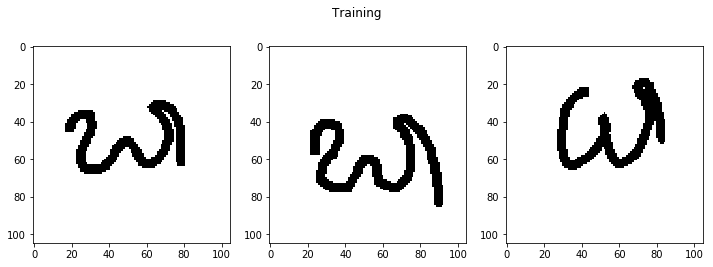

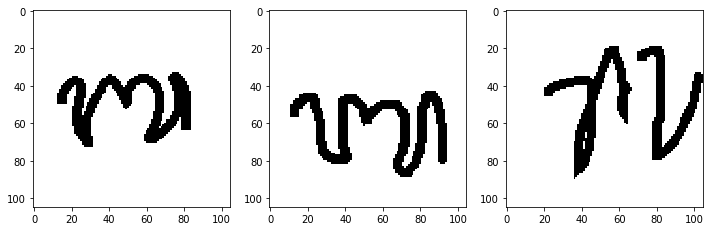

In [20]:
plt.figure(figsize=(12, 4))
plt.suptitle("Training")
plt.subplot(131)
plt.imshow(get_image('Balinese', 'character01', '0108_01'))
plt.subplot(132)
plt.imshow(get_image('Balinese', 'character01', '0108_02'))
plt.subplot(133)
plt.imshow(get_image('Balinese', 'character01', '0108_03'))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(get_image('Balinese', 'character02', '0109_01'))
plt.subplot(132)
plt.imshow(get_image('Balinese', 'character02', '0109_02'))
plt.subplot(133)
_ = plt.imshow(get_image('Balinese', 'character02', '0109_03'))

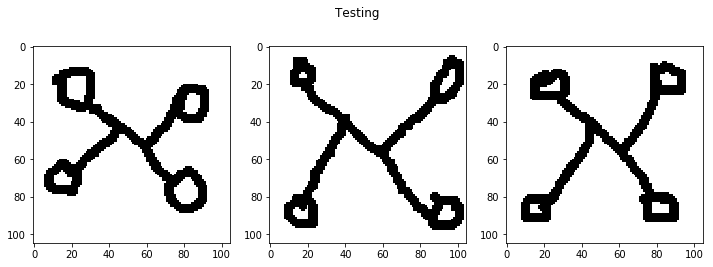

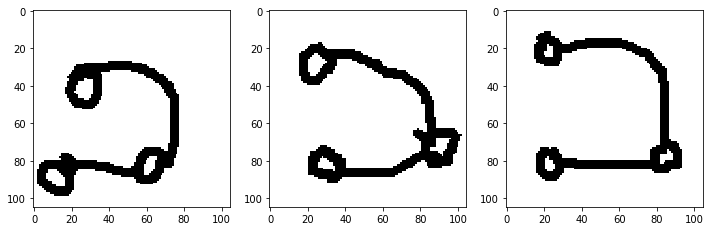

In [21]:
plt.figure(figsize=(12, 4))
plt.suptitle("Testing")
plt.subplot(131)
plt.imshow(get_image('Angelic', 'character01', '0965_01', "Test"))
plt.subplot(132)
plt.imshow(get_image('Angelic', 'character01', '0965_02', "Test"))
plt.subplot(133)
plt.imshow(get_image('Angelic', 'character01', '0965_03', "Test"))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(get_image('Angelic', 'character02', '0966_01', "Test"))
plt.subplot(132)
plt.imshow(get_image('Angelic', 'character02', '0966_02', "Test"))
plt.subplot(133)
_ = plt.imshow(get_image('Angelic', 'character02', '0966_03', "Test"))

## Training strategy

- Train network on the verification task
    - identify input pairs according to the probability that they belong to the same or different classes
- Validate model 
    - classification accuracy
    - one-shot learning

### Verification task

Omniglot dataset is used to randomly produce *same* and *different* pairs of images.

In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
class OmniglotDataset(Dataset):
    
    def __init__(self, dataset_type="Train", data_path="", alphabet_char_id_drawers_ids={}, drawers_ids=None, shuffle=True):        
        assert dataset_type in ["Train", "Test"]
        assert len(alphabet_char_id_drawers_ids) > 0
        super(OmniglotDataset, self).__init__()
        self.dataset_type = dataset_type
        self.data_path = data_path
        self.alphabet_char_id_drawers_ids = alphabet_char_id_drawers_ids
        self.drawers_ids = drawers_ids
        self.shuffle = shuffle
        
        if drawers_ids is None:
            drawer_cond_fn = lambda _id: True
        else:
            drawer_cond_fn = lambda _id: str(_id[-3:]) in drawers_ids
            
        self.data_ids = []
        for a in alphabet_char_id_drawers_ids:            
            alphabet_char_ids = alphabet_char_id_drawers_ids[a]
            for char_id in alphabet_char_ids:
                p = os.path.join(a, char_id)
                self.data_ids.extend([os.path.join(p, "%s.png" % _id) for _id in alphabet_char_ids[char_id] 
                                      if drawer_cond_fn(_id)])
            
    def _get_image(self, image_id):    
        path = os.path.join(self.data_path, image_id)
        assert os.path.exists(path), "Path '%s' does not exist" % path
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        return np.expand_dims(img, axis=-1)
        
    def _get_label(self, image_id):
        # Remove .png and char id from the image_id
        return os.path.dirname(image_id)
    
    def __len__(self):
        return len(self.data_ids)
    
    def __getitem__(self, index):
        return self._get_image(self.data_ids[index]), self._get_label(self.data_ids[index])    

#### Dataset splitting:    
- Training:
    - random 30 of 50 alphabets
    - random 12 of 20 drawers     
    - 3 types of training datasets : 
        - 30k of pairs
        - 90k of pairs
        - 150k of pairs    
- Validation:
    - remaining 10 of 20 alphabets
    - remaining 4 of 8 alphabets
    - 10k of pairs
- Testing:
    - remaining 10 of 20 alphabets
    - remaining 4 of 8 alphabets
    - 10k of pairs


In [24]:
np.random.seed(12345)

In [25]:
# Sample 12 drawers out of 20
all_drawers_ids = np.arange(20) 
train_drawers_ids = np.random.choice(all_drawers_ids, size=12, replace=False)
# Sample 4 drawers out of remaining 8
val_drawers_ids = np.random.choice(list(set(all_drawers_ids) - set(train_drawers_ids)), size=4, replace=False)
test_drawers_ids = np.array(list(set(all_drawers_ids) - set(val_drawers_ids) - set(train_drawers_ids)))

def create_str_drawers_ids(drawers_ids):
    return ["_{0:0>2}".format(_id) for _id in drawers_ids]

train_drawers_ids = create_str_drawers_ids(train_drawers_ids)
val_drawers_ids = create_str_drawers_ids(val_drawers_ids)
test_drawers_ids = create_str_drawers_ids(test_drawers_ids)

In [26]:
print(train_drawers_ids)
print(val_drawers_ids)
print(test_drawers_ids)

['_13', '_08', '_16', '_03', '_15', '_12', '_00', '_10', '_07', '_11', '_06', '_17']
['_09', '_18', '_19', '_14']
['_01', '_02', '_04', '_05']


In [27]:
train_ds = OmniglotDataset("Train", data_path=TRAIN_DATA_PATH, 
                           alphabet_char_id_drawers_ids=train_alphabet_char_id_drawer_ids, 
                           drawers_ids=train_drawers_ids)

val_ds = OmniglotDataset("Test", data_path=TEST_DATA_PATH, 
                         alphabet_char_id_drawers_ids=test_alphabet_char_id_drawer_ids, 
                         drawers_ids=val_drawers_ids)

test_ds = OmniglotDataset("Test", data_path=TEST_DATA_PATH, 
                          alphabet_char_id_drawers_ids=test_alphabet_char_id_drawer_ids, 
                          drawers_ids=test_drawers_ids)

In [28]:
len(train_ds), len(val_ds), len(test_ds)

(10604, 2636, 2636)

In [29]:
y_labels = set()
for x, y in train_ds:
    y_labels.add(y)

In [30]:
# Number of classes
len(y_labels), x.shape

(964, (105, 105, 1))

In [31]:
# number of alphabets:
res = set([y_label.split('/')[0] for y_label in y_labels])
len(res), res

(30,
 {'Alphabet_of_the_Magi',
  'Anglo-Saxon_Futhorc',
  'Arcadian',
  'Armenian',
  'Asomtavruli_(Georgian)',
  'Balinese',
  'Bengali',
  'Blackfoot_(Canadian_Aboriginal_Syllabics)',
  'Braille',
  'Burmese_(Myanmar)',
  'Cyrillic',
  'Early_Aramaic',
  'Futurama',
  'Grantha',
  'Greek',
  'Gujarati',
  'Hebrew',
  'Inuktitut_(Canadian_Aboriginal_Syllabics)',
  'Japanese_(hiragana)',
  'Japanese_(katakana)',
  'Korean',
  'Latin',
  'Malay_(Jawi_-_Arabic)',
  'Mkhedruli_(Georgian)',
  'N_Ko',
  'Ojibwe_(Canadian_Aboriginal_Syllabics)',
  'Sanskrit',
  'Syriac_(Estrangelo)',
  'Tagalog',
  'Tifinagh'})

Create pairs

In [32]:
from collections import defaultdict

from common.dataflow import ProxyDataset

In [33]:
def _create_same_pairs(labels_indices, nb_samples_per_class):
    same_pairs = []
    for indices in labels_indices.values():
        same_pairs.extend([np.random.choice(indices, size=2, replace=False) for _ in range(nb_samples_per_class)])
    return np.array(same_pairs)


def _create_diff_pairs(labels_indices, nb_samples_per_two_classes):
    diff_pairs = []
    for i, indices1 in enumerate(labels_indices.values()):
        for j, indices2 in enumerate(labels_indices.values()):
            if (i <= j):
                continue
            ind1 = np.random.choice(indices1, size=nb_samples_per_two_classes)
            ind2 = np.random.choice(indices2, size=nb_samples_per_two_classes)
            diff_pairs.extend([[_i, _j] for _i, _j in zip(ind1, ind2)])
    return np.array(diff_pairs)

class SameOrDifferentPairsDataset(ProxyDataset):
    """
    Create a dataset of pairs uniformly sampled from input dataset
    Pairs are set of two images classified as 
        - 'same' if images are from the same class
        - 'different' if images are from different classes            
    """
    
    def __init__(self, ds, nb_pairs, shuffle=True):
        super(SameOrDifferentPairsDataset, self).__init__(ds)
        self.nb_pairs = nb_pairs
        # get mapping y_label -> indices
        labels_indices = defaultdict(list)
        alphabet_indices = defaultdict(list)        
        for i, (_, y) in enumerate(ds):
            alphabet_indices[y].append(i)
            y = y.split("/")[0]
            labels_indices[y].append(i)
        
        half_nb_pairs = int(nb_pairs//2)
        n1 = int(np.ceil(half_nb_pairs / len(alphabet_indices)))
        same_pairs = _create_same_pairs(alphabet_indices, n1)
        if len(same_pairs) > half_nb_pairs:
            same_pairs = same_pairs[:half_nb_pairs, :]
        
        n2 = int(np.ceil(nb_pairs / (len(labels_indices) * (len(labels_indices) - 1))))
        diff_pairs = _create_diff_pairs(labels_indices, n2)
        if len(diff_pairs) > half_nb_pairs:
            diff_pairs = diff_pairs[:half_nb_pairs, :]
        
        self.pairs = np.concatenate((same_pairs, diff_pairs), axis=0)
        np.random.shuffle(self.pairs)
            
    def __len__(self):
        return self.nb_pairs
        
    def __getitem__(self, index):
        i1, i2 = self.pairs[index, :]
        x1, y1 = self.ds[i1]
        x2, y2 = self.ds[i2]                
        return x1, x2, int(y1 == y2)

In [34]:
train_pairs = SameOrDifferentPairsDataset(train_ds, nb_pairs=int(30e3))
val_pairs = SameOrDifferentPairsDataset(val_ds, nb_pairs=int(10e3))
test_pairs = SameOrDifferentPairsDataset(test_ds, nb_pairs=int(10e3))

In [35]:
len(train_pairs), len(val_pairs), len(test_pairs)

(30000, 10000, 10000)

#### Data augmentations

Random affine transformation with 0.5 probability: 
- rotation: [-10, 10]
- scale: [0.8, 1.2]
- translations: [-2, 2]
- shear: [-0.3, 0.3]

In [36]:
from common.imgaug import RandomAffine, RandomApply
from common.dataflow import TransformedDataset
from torchvision.transforms import Compose, ToTensor, Normalize

In [37]:
train_data_aug = Compose([
    RandomApply(
        RandomAffine(rotation=(-10, 10), scale=(0.8, 1.2), translate=(-0.05, 0.05)),
        proba=0.5
    ),
    ToTensor()
])

In [38]:
class PairTransformedDataset(TransformedDataset):    
    def __getitem__(self, index):
        x1, x2, y = self.ds[index]
        x1 = self.x_transforms(x1)
        x2 = self.x_transforms(x2) 
        if self.y_transforms is not None:
            y = self.y_transforms(y)
        return x1, x2, y

In [39]:
train_aug_pairs = PairTransformedDataset(train_pairs, x_transforms=train_data_aug)

In [40]:
from common.dataflow_visu_utils import _to_ndarray

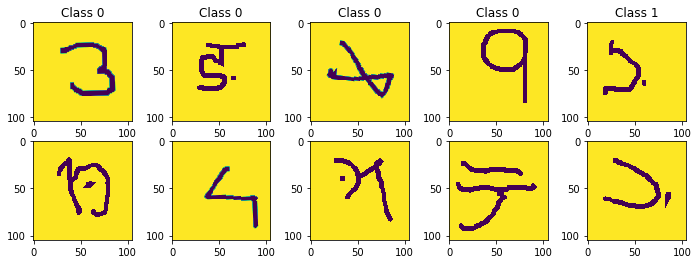

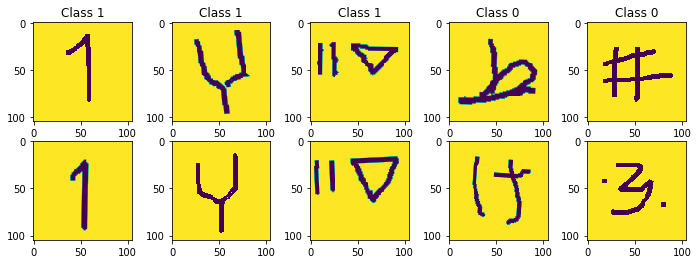

In [41]:
max_datapoints = 10
n_cols = 5
for i, (x1, x2, y) in enumerate(train_aug_pairs):

    if i % n_cols == 0:
        plt.figure(figsize=(12, 4))

    x1 = _to_ndarray(x1)
    x2 = _to_ndarray(x2)    
    plt.subplot(2, n_cols, (i % n_cols) + 1)
    plt.imshow(x1)
    plt.title("Class %i" % y)
    plt.subplot(2, n_cols, (i % n_cols) + 1 + n_cols)
    plt.imshow(x2)

    max_datapoints -= 1
    if max_datapoints == 0:
        break

Batch loader

In [42]:
batch_size = 5
train_batches = DataLoader(train_aug_pairs, batch_size=batch_size, 
                           shuffle=True, num_workers=5,                      
                           drop_last=True)
# val_batches = DataLoader(val_pairs, batch_size=batch_size, 
#                               shuffle=True, num_workers=5,
#                               pin_memory=True, drop_last=True)
# test_batches = DataLoader(test_pairs, batch_size=batch_size, 
#                                shuffle=True, num_workers=5,                   
#                                pin_memory=True, drop_last=True)

In [43]:
len(train_batches)

6000

torch.Size([5, 1, 105, 105]) torch.Size([5, 1, 105, 105]) torch.Size([5])
torch.Size([5, 1, 105, 105]) torch.Size([5, 1, 105, 105]) torch.Size([5])


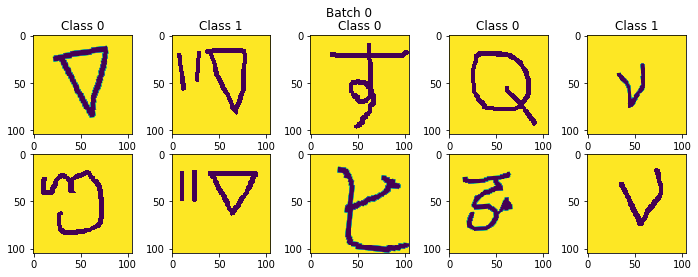

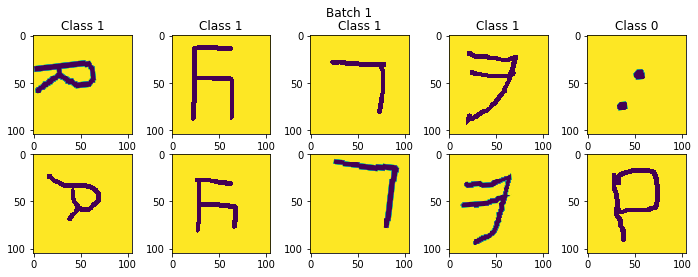

In [44]:
max_datapoints = 2
n_cols = 5
for i, (batch_x1, batch_x2, batch_y) in enumerate(train_batches):

    print(batch_x1.size(), batch_x2.size(), batch_y.size())
    
    plt.figure(figsize=(12, 4))
    plt.suptitle("Batch %i" % i)
    for j in range(len(batch_x1)):
        if j > 0 and j % n_cols == 0:
            plt.figure(figsize=(16, 4))
        
        x1 = batch_x1[j, ...]
        x2 = batch_x2[j, ...]
        y = batch_y[j, ...]
    
        x1 = _to_ndarray(x1)
        x2 = _to_ndarray(x2)    
        plt.subplot(2, n_cols, (j % n_cols) + 1)
        plt.imshow(x1)
        plt.title("Class %i" % y)
        plt.subplot(2, n_cols, (j % n_cols) + 1 + n_cols)
        plt.imshow(x2)

    max_datapoints -= 1
    if max_datapoints == 0:
        break

#### Weight regularization

L2 weights regularization: 

#### Loss function

Binary cross-entropy

In [45]:
from torch.nn import CrossEntropyLoss
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

In [46]:
from torch.backends import cudnn
cudnn.benchmark = True

In [47]:
from common.dataflow import OnGPUDataLoader

In [48]:
from datetime import datetime
from common.training_utils import train_one_epoch, validate, write_csv_log, write_conf_log, verbose_optimizer, save_checkpoint

In [56]:
siamese_net = SiameseNetworks(input_shape=(105, 105, 1)).cuda()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/torch/lib/THC/generic/THCTensorCopy.c:18

In [49]:
conf = {
    'weight_decay': 0.01,
    'lr_features': 0.001,
    'lr_classifier': 0.01,
    
    'n_epochs': 10,
    'batch_size': 32,
    
    'gamma': 0.99
}

In [50]:
criterion = CrossEntropyLoss().cuda()

In [51]:
optimizer = RMSprop([{
    'params': siamese_net.net.features.parameters(),
    'lr': conf['lr_features'],    
}, {
    'params': siamese_net.classifier.parameters(),
    'lr': conf['lr_classifier']
}], 
    eps=1.0, 
    weight_decay=conf['weight_decay']
)

In [52]:
# lr <- lr_init * gamma ** epoch
scheduler = ExponentialLR(optimizer, gamma=conf['gamma'])
onplateau_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

Start training

In [53]:
now = datetime.now()
logs_path = os.path.join('logs', 'seamese_networks_verification_task_%s' % (now.strftime("%Y%m%d_%H%M")))
if not os.path.exists(logs_path):
    os.makedirs(logs_path)

In [55]:
write_conf_log(logs_path, "{}".format(conf))
write_conf_log(logs_path, verbose_optimizer(optimizer))

train_batches = OnGPUDataLoader(train_aug_pairs, batch_size=conf['batch_size'], 
                                shuffle=True, num_workers=8, 
                                pin_memory=True, drop_last=True)

val_batches = OnGPUDataLoader(val_pairs, batch_size=conf['batch_size'], 
                              shuffle=True, num_workers=8, 
                              pin_memory=True, drop_last=True)

write_csv_log(logs_path, "epoch,train_loss,train_prec1,val_loss,val_prec1")

best_prec1 = 0.0
for epoch in range(conf['n_epochs']):
    scheduler.step()
    # Verbose learning rates:
    print(verbose_optimizer(optimizer))

    # train for one epoch
    train_loss, train_prec1 = train_one_epoch(siamese_net, train_batches, 
                                              criterion, optimizer, 
                                              epoch, conf['n_epochs'])
    assert train_loss, train_prec1

    # evaluate on validation set
    val_loss, val_prec1 = validate(siameze_net, val_batches, criterion)
    assert val_loss, val_prec1
    onplateau_scheduler.step(val_loss)

    # Write a csv log file
    write_csv_log(logs_path, "%i,%f,%f,%f,%f" % (epoch, train_loss, train_prec1, val_loss, val_prec1))

    # remember best prec@1 and save checkpoint
    if val_prec1 > best_prec1:
        best_prec1 = max(val_prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': siameze_net.state_dict(),
            'val_prec1': val_prec1,
            'optimizer': optimizer.state_dict()
        })        

  0%|          | 0/937 [00:00<?, ?it/s]


Optimizer: RMSprop
Optimizer parameters: 
- Param group: 
	lr: 0.00099
	initial_lr: 0.001
	alpha: 0.99
	weight_decay: 0.01
	momentum: 0
	eps: 1.0
	centered: False
- Param group: 
	lr: 0.0099
	initial_lr: 0.01
	alpha: 0.99
	weight_decay: 0.01
	momentum: 0
	eps: 1.0
	centered: False



RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/torch/lib/THC/generic/THCTensorCopy.c:126

In [60]:
!nvidia-smi

Sat Nov 18 01:04:07 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 0000:02:00.0     Off |                  N/A |
| 31%   55C    P2    78W / 250W |   1221MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### One-shot learning evaluation

